In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'electronic_gen_5_testing'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
all_data = all_data[(all_data['class'] == 'LETTERS') | (all_data['class'] == 'ELECTRONIC')]
all_data = all_data[all_data['after'].str.len() > 5]
all_data.sample(2)
len(all_data)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
9635208,727208,12,LETTERS,Eora,e o r a,LETTERS,"[28, 25, 35, 22, 0]",clark was also quite friendly with local abori...
2720491,210686,5,ELECTRONIC,WebMineral.com,w e b m i n e r a l dot c o m,ELECTRONIC,"[52, 28, 36, 32, 31, 29, 28, 35, 22, 42, 74, 2...","alum ( na ) , <SAMPLE> , retrieved 2009 - 11 -..."


32992

In [7]:
sample_data = all_data.copy()
sample_data = sample_data.reset_index(drop=True)
del(all_data)

sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] == 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

In [8]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS']
2


In [9]:
sample_data.sample(2)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
14581,339016,5,LETTERS,CFAC,c f a c,LETTERS,"[21, 37, 22, 21, 0]","since its opening , the <SAMPLE> has hosted ov..."
12241,282249,3,ELECTRONIC,apl.de.ap,a p l dot d e dot a p,ELECTRONIC,"[22, 24, 42, 74, 26, 28, 74, 22, 24, 0]",""" look : <SAMPLE> returns as ' voice ph ' coac..."


### Utils stuff

In [10]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [11]:
arr = list(sample_data['after'])
arr = [s.split(' ') for s in arr]
words_after = [EOS_TOKEN, SOS_TOKEN, UNKNOWN_WORD_TOKEN, NUMBER_WORD_TOKEN, SAMPLE_WORD_TOKEN]
words_after = words_after + sorted(list(set(np.concatenate(arr))))
words_after_index = dict((c, i) for i, c in enumerate(words_after))
words_after_by_length = sorted(words_after, key=len, reverse=True)
words_after_regex = re.compile('(' + ')|('.join(words_after_by_length) + ')')

In [12]:
len(words_after)

152

chars_after = [EOS_TOKEN, SOS_TOKEN] + sorted(list(set(list(''.join(list(sample_data['after']))))))
chars_after_index = dict((c, i) for i, c in enumerate(chars_after))
''.join(chars_after)

In [13]:
def after_sentence_to_word_indexes(sentence, include_eos=True):
    reg = re.finditer(words_after_regex, sentence)
    arr = [words_after_index[s[0]] for s in reg]
    if include_eos:
        arr += [words_after_index[EOS_TOKEN]]
    return arr
tmp = after_sentence_to_word_indexes('dot d o c')
tmp
[words_after[t] for t in tmp]

[32, 26, 92, 19, 0]

['dot', 'd', 'o', 'c', '<EOS>']

In [14]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 152])

### Samples

In [15]:
balanced_data_length = len(sample_data)
def get_random_sample():
    #sample_row = balanced_data_sample_row()
    sample_row = balanced_data_last_sample = sample_data.iloc[random.randint(1, balanced_data_length-1)]
    
    a_words_ind = after_sentence_to_word_indexes(sample_row['after'], include_eos=True)
    return sample_row['before'], a_words_ind
            
def tmp():
    s_bef, s_aft = get_random_sample()
    s_aft_str = ' '.join([words_after[i] for i in s_aft])
    print(s_bef, '->', s_aft_str, s_aft)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

RPGs -> r p g's <EOS> [109, 100, 53, 0]
torch.Size([1, 5, 104])


In [16]:
%%timeit
get_random_sample()

249 µs ± 8.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Model functions

In [17]:
use_cuda = True

In [18]:
MAX_ATTENTION_LENGTH = 50

In [19]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
tmp[~tmp['before'].str.contains('/')].sample(2)

498

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
18870,440736,3,ELECTRONIC,http://tvbythenumbers.zap2it.com/2010/09/07/sy...,h t t p colon slash slash t v b y t h e n u m ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 30, 54, 36, 86...","retrieved 2010 - 09 - 07 . <SAMPLE> , stuart (..."
2047,52595,8,ELECTRONIC,https://www.eastleigh.gov.uk/the-council/mayor...,h t t p s colon slash slash w w w dot e a s t ...,ELECTRONIC,"[45, 30, 30, 24, 17, 129, 101, 101, 52, 52, 52...",memoirs of the american academy in rome 12 <SA...


,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
21453,491251,1,ELECTRONIC,StoneDeadline.comDeadline.comDeadline.comDeadl...,s t o n e d e a d l i n e dot c o m d e a d l ...,ELECTRONIC,"[17, 30, 25, 29, 28, 26, 28, 22, 26, 42, 31, 2...",deadline . comdeadline . comvarietydeadline . ...
11533,265794,3,ELECTRONIC,2000Myspace.comTempleofschlock.blogpsot.comBil...,t w o o o o m y s p a c e dot c o m t e m p l ...,ELECTRONIC,"[30, 52, 25, 25, 25, 25, 32, 86, 17, 24, 22, 2...","7th edn , <SAMPLE> vol 89 # 8 ( 26 february 19..."


### Encoder

In [88]:
class EncoderRNN(nn.Module):
    def __init__(self, chars_input_size, chars_hidden_size, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.chars_layers = chars_layers
        self.chars_hidden_size = chars_hidden_size

        #self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size//2, chars_layers,
        #                         # batch_first=True, bidirectional=False)
        #                         batch_first=True, bidirectional=True)
        
        self.rnn_chars = nn.GRU(chars_input_size, chars_hidden_size//2, chars_layers,
                         # batch_first=True, bidirectional=False)
                         batch_first=True, bidirectional=True)
        
    def forward(self, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_chars = self.init_hidden()
        
        #all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars[0])
        
        return all_outputs_chars, hidden_chars
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = all_outputs_chars[0, ei]
                
        #return output, all_outputs_chars
        return output_chars[0], hidden_states_cat

    def init_hidden(self):
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size//2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size//2))
        
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return (var2_1, var2_2)
    
    
encoder_rnn = EncoderRNN(chars_input_size=len(chars_normal),
                         chars_hidden_size=256, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_chars): GRU(104, 128, batch_first=True, bidirectional=True)
)

In [153]:
string_t.size()

torch.Size([1, 5, 104])

In [190]:
rnn_chars = encoder_rnn.rnn_chars
hidden = Variable(torch.zeros(2, 1, 256//2)).cuda()

In [304]:
hidden = Variable(torch.zeros(2, 1, 256//2)).cuda()
hidden_2 = Variable(torch.zeros(2, 1, 256//2)).cuda()
arr = [] 
arr2 = [] 
for i in range(1):#range(len(s_bef)):
    rnn_result, hidden = rnn_chars(string_t[:,i].unsqueeze(0), hidden)
    arr.append(rnn_result)
    
    rnn_result_2, hidden_2 = rnn_chars(string_t[:,-i].unsqueeze(0), hidden_2)
    arr2.append(rnn_result_2)
len(arr)

1

In [305]:
arr[0].size()

torch.Size([1, 1, 256])

In [306]:
hidden.size()

torch.Size([2, 1, 128])

In [308]:
(arr[-1][0,0,:128] == hidden[0,0]).data.all()
(arr[-1][0,0,128:] == hidden[1,0]).data.all()

True

True

In [267]:
rnn_result[0,0,:128] == rnn_result[0,0,128:]

Variable containing:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.cuda.ByteTensor of size 128 (GPU 0)]

In [258]:
# hidden[0,0] == tmp_b[0,0]

In [191]:
string_t[:,0].unsqueeze(0).size()

torch.Size([1, 1, 104])

In [170]:
a,b = rnn_chars(string_t[:,0].unsqueeze(0), hidden)
a.size()
b.size()

torch.Size([1, 1, 256])

torch.Size([2, 1, 128])

In [188]:
(a[0, -1][:128] == b[0][0]).data.all()

True

In [189]:
(a[0, -1][128:] == b[1][0]).data.all()

True

In [187]:
(tmp_a[0, -1][:128] == tmp_b[0][0]).data.all()

True

In [185]:
(tmp_a[0, 0][128:] == tmp_b[1][0]).data.all()

True

In [143]:
(a==tmp_a).data.all()
(b==tmp_b).data.all()

True

True

In [313]:
#s_bef, s_aft = get_random_sample()
s_bef
string_t = string_to_tensor(s_bef, chars_normal_index, include_eos=False)
string_t = Variable(string_t).cuda()
 
tmp_a, tmp_b = encoder_rnn(string_t)
tmp_a.size()

'ISBN'

torch.Size([1, 4, 256])

In [314]:
tmp_b.size()

torch.Size([2, 1, 128])

In [315]:
tmp_b[0].size()
tmp_b[1].size()

torch.Size([1, 128])

torch.Size([1, 128])

In [316]:
tmp_a.size()

torch.Size([1, 4, 256])

In [317]:
torch.eq(tmp_a[0, -1][:128], tmp_b[0][0]).data.all()

True

In [318]:
torch.eq(tmp_a[0, 0][128:], tmp_b[1][0]).data.all()

True

In [320]:
tmp_b.view(1,-1).size()

torch.Size([1, 256])

In [322]:
ten = torch.ones(1,5)
ten


 1  1  1  1  1
[torch.FloatTensor of size 1x5]

In [323]:
nn.Padding(30, pad, ndim, 0)

AttributeError: module 'torch.nn' has no attribute 'Padding'

In [94]:
torch.eq(tmp_a[0, -1][128:], tmp_b[0][0]).data.all()

False

In [95]:
#torch.eq(tmp_a[0, 0][128:], tmp_b[0][1]).data.all()

IndexError: index 1 is out of range for dimension 0 (of size 1)

In [332]:
var = Variable(torch.zeros(10, 256)).cuda() 
var[0:4, :] = tmp_a[0]

In [340]:
var[3] == tmp_a[0, 3]

Variable containing:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.cuda.ByteTensor of size 256 (GPU 0)]

In [326]:
tmp_a.size()

torch.Size([1, 4, 256])

In [54]:
tmp_b[0]

Variable containing:
( 0 ,.,.) = 

Columns 0 to 5 
  -3.5901e-02  3.3424e-02  2.1086e-02  2.6456e-02  3.2424e-03 -2.8453e-02

Columns 6 to 11 
  -3.9658e-03  2.9822e-03 -9.1939e-03 -4.9068e-02 -5.9038e-02 -3.0173e-03

Columns 12 to 17 
   1.4003e-02  5.4032e-02 -2.7449e-02 -2.0977e-02 -3.9236e-02  1.7325e-02

Columns 18 to 23 
  -1.7254e-02  6.0257e-02 -4.1839e-02 -2.7712e-02  9.0128e-02 -2.7616e-02

Columns 24 to 29 
  -2.8029e-02  2.4453e-02 -2.6970e-02 -5.7464e-02 -6.2279e-02 -1.7502e-04

Columns 30 to 35 
  -1.7628e-02  3.1261e-02  3.3015e-02  5.2114e-02 -5.2699e-02  3.3634e-02

Columns 36 to 41 
   3.8681e-03  1.1507e-02  1.7050e-02 -1.2760e-02 -1.7624e-02  1.0668e-02

Columns 42 to 47 
   6.3007e-02  6.3538e-02  7.1745e-02 -2.5703e-02 -6.8111e-02  3.3389e-02

Columns 48 to 53 
   1.0935e-02  4.9186e-02  5.2750e-02  1.3243e-02 -6.2038e-02 -2.4470e-02

Columns 54 to 59 
  -3.3816e-02 -5.6037e-02 -6.7744e-02 -1.0007e-02  4.5078e-03 -5.5131e-03

Columns 60 to 65 
   4.6660e-02 -3.562

In [53]:
tmp_a[0, -1]

Variable containing:
-3.5901e-02
 3.3424e-02
 2.1086e-02
 2.6456e-02
 3.2424e-03
-2.8453e-02
-3.9658e-03
 2.9822e-03
-9.1939e-03
-4.9068e-02
-5.9038e-02
-3.0173e-03
 1.4003e-02
 5.4032e-02
-2.7449e-02
-2.0977e-02
-3.9236e-02
 1.7325e-02
-1.7254e-02
 6.0257e-02
-4.1839e-02
-2.7712e-02
 9.0128e-02
-2.7616e-02
-2.8029e-02
 2.4453e-02
-2.6970e-02
-5.7464e-02
-6.2279e-02
-1.7502e-04
-1.7628e-02
 3.1261e-02
 3.3015e-02
 5.2114e-02
-5.2699e-02
 3.3634e-02
 3.8681e-03
 1.1507e-02
 1.7050e-02
-1.2760e-02
-1.7624e-02
 1.0668e-02
 6.3007e-02
 6.3538e-02
 7.1745e-02
-2.5703e-02
-6.8111e-02
 3.3389e-02
 1.0935e-02
 4.9186e-02
 5.2750e-02
 1.3243e-02
-6.2038e-02
-2.4470e-02
-3.3816e-02
-5.6037e-02
-6.7744e-02
-1.0007e-02
 4.5078e-03
-5.5131e-03
 4.6660e-02
-3.5627e-02
 4.5711e-02
 1.9766e-03
-3.8702e-02
-2.1316e-02
-8.7357e-02
 5.6672e-02
 6.1361e-03
-6.1340e-02
 5.6640e-03
-1.3068e-02
 1.9688e-02
-1.1813e-01
-1.2725e-02
-2.2661e-02
-5.3302e-02
 1.7122e-02
-7.5270e-02
-1.3934e-02
-7.4152e-05
 2.0420

In [29]:
string_t.size()

torch.Size([1, 6, 104])

In [36]:
tmp[0,:,:tmp.size()[2]//2].size()

torch.Size([6, 128])

In [29]:
def test_encoder_single_sample():
    s_bef, s_aft = get_random_sample()

    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

'NAZARETHANA'

torch.Size([256])

torch.Size([50, 256])

True

### Decoder

In [30]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.lin_out = nn.Linear(hidden_size, input_size)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        rnn_input = torch.cat((embedded[0], attn_applied[0]), 1)
        rnn_input = self.attn_combine(rnn_input).unsqueeze(0)
        rnn_input = F.relu(rnn_input)
        
        output, hidden = self.rnn(rnn_input, hidden)
        output = F.log_softmax(self.lin_out(output[0]))
        
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
#[v.size() for v in tmp]

DecoderRNN (
  (emb_lin): Linear (152 -> 256)
  (attn): Linear (512 -> 50)
  (attn_combine): Linear (512 -> 256)
  (dropout): Dropout (p = 0.1)
  (rnn): GRU(256, 256, batch_first=True)
  (lin_out): Linear (256 -> 152)
)

In [31]:
sos_tensor.size()
tmp_hiddens.size()
tmp_outputs.size()

torch.Size([1, 1, 152])

torch.Size([1, 1, 256])

torch.Size([50, 256])

In [32]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 152]), torch.Size([1, 1, 256]), torch.Size([1, 50])]

Variable containing:
 103
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

plus


# Training etc

### Accuracy

In [33]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft = sample
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(string_t)
        
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus',
 'plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus',
 'g e r d a b dot i r',
 ('gerdab.ir', [52, 33, 109, 26, 5, 13, 32, 65, 109, 0]))

In [34]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', '' ))
print_local_wrong_predictions(2)

NHPTV          => plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus || [87, 59, 100, 124, 138, 0] 
                  
ISTE           => plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus plus || [65, 113, 124, 33, 0] 
                  


In [35]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s


0.0

### Training

In [36]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [37]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft = get_random_sample()
        s_sentence=''
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [38]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/electronic_gen_4_testing_no_words


In [39]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   5.024   |   5.00: NARSTIE -> plus plus plus plus plus plus plus plus (✗: n a r s t i e) 
Saved model to data/models/electronic_gen_4_testing_no_words/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (  3m 34s)   4.399   |   4.97: IRRI -> <EOS> <EOS> <EOS> <EOS> (✗: i r r i) (forcing)
    27  54% (  3m 34s)   4.143   |   4.93: ISBN -> <EOS> <EOS> <EOS> <EOS> (✗: i s b n) (forcing)
    36  72% (  3m 35s)   3.791   |   1.00: PFLP ->  (✗: p f l p) 
    45  90% (  3m 35s)   3.547   |   0.29: ThisIsKent.co.uk ->  (✗: t h i s i s k e n t dot c o dot u k) 


In [40]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 8s)   2.351   |   2.63: ISBN -> i s <EOS> <EOS> (✗: i s b n) (forcing)


In [41]:
train_iterations(n_iters=99000, print_every=10000)

 11000  10% (  4m 28s)   0.225   |   1.33: Browseinside.harpercollins.com -> b r o w s e i n s i d e dot h r m <EOS> p s dot o r a s s h h c o m (✗: b r o w s e i n s i d e dot h a r p e r c o l l i n s dot c o m) (forcing)
 21000  20% (   9m 4s)   0.140   |   0.00: Ofie -> o f i e (✓) 
 31000  30% ( 13m 29s)   0.118   |   0.01: é -> e acute (✓) 
 41000  40% ( 17m 58s)   0.141   |   0.02: Iida's -> i i d a's (✓) (forcing)
Saved model to data/models/electronic_gen_4_testing_no_words/50000_(EncoderRNN/DecoderRNN)
Accuracy: 92.51% (    9251/   10000)
 51000  51% ( 23m 39s)   0.119   |   0.01: srpskih -> s r p s k i h (✓) 
 61000  61% (  28m 7s)   0.139   |   2.73: U.T.O.P.I.A. -> u l t p o m m (✗: u t o p i a) 
 71000  71% ( 32m 26s)   0.354   |   0.03: TNA's -> t n a's (✓) 
 81000  81% ( 36m 46s)   0.189   |   0.02: NGOs -> n g o's (✓) 
 91000  91% (  41m 4s)   0.688   |   0.98: WHYN's -> w h y n (✗: w h y n's) 
Saved model to data/models/electronic_gen_4_testing_no_words/100000_(Encoder

In [42]:
train_iterations(n_iters=100000, print_every=10000)

110000  10% (  4m 15s)   0.425   |   0.01: ISBN -> i s b n (✓) (forcing)
120000  20% (  8m 36s)   0.662   |   0.05: E&M -> e and m (✓) (forcing)
130000  30% (  13m 1s)   0.725   |   0.03: WJLA -> w j l a (✓) 
140000  40% ( 17m 19s)   0.549   |   0.02: SBAO -> s b a o (✓) 
150000  50% ( 21m 40s)   0.489   |   0.01: ADMN -> a d m n (✓) 
Saved model to data/models/electronic_gen_4_testing_no_words/150000_(EncoderRNN/DecoderRNN)
Accuracy: 75.45% (    7545/   10000)
160000  60% ( 27m 27s)   0.467   |   0.07: DFAT -> d f a t (✓) 
170000  70% (  32m 7s)   0.878   |   0.11: Lidl -> l i d l (✓) (forcing)
180000  80% ( 36m 28s)   0.713   |   0.05: WDSE -> w d s e (✓) 


KeyboardInterrupt: 

### Show attention

input:   DHAMOIRHAT
output:  d h a t h d t h h h h h h e
target:    dhamoirhat


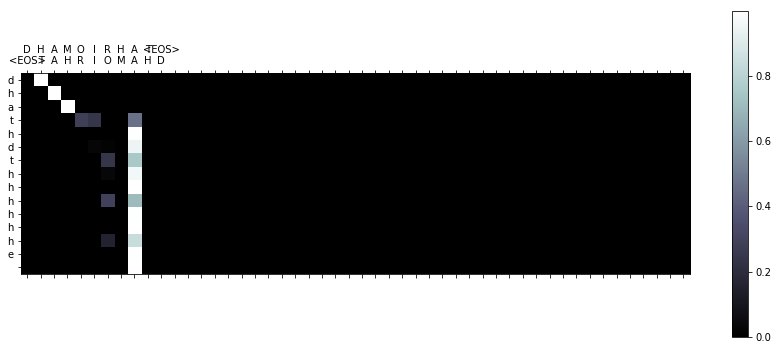

In [55]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input:  ', sample[0])
    print('output: ', ' '.join(decoded_output))
    print('target:   ', ''.join([words_after[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [ ]:
1+1